# Semantic segmentation

In [17]:
from config2py import config_getter
OPENAI_API_KEY = config_getter("OPENAI_API_KEY")

In [9]:
import nltk
from nltk.tokenize import sent_tokenize

# Download the necessary NLTK data files (only needed once)
nltk.download('punkt')
# Segment the text into sentences
sentence_splits = sent_tokenize
sentence_splits.__name__ = "sentence_splits"


[nltk_data] Downloading package punkt to /Users/alexis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
import numpy as np
from langchain_openai import OpenAIEmbeddings
from config2py import config_getter

OPENAI_API_KEY = config_getter("OPENAI_API_KEY")

def sentence_embeddings(meaningful_sentences, api_key):
    embeddings_model = OpenAIEmbeddings(api_key=OPENAI_API_KEY, model="text-embedding-3-small", dimensions=512)
    return np.array(embeddings_model.embed_documents(meaningful_sentences))

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
def consecutive_cosines(sentence_embeddings):
    z = zip(sentence_embeddings, sentence_embeddings[1:])
    cosines = [cosine_similarity([a], [b])[0][0] for a,b in z]
    return cosines

In [25]:
from scipy.signal import find_peaks
def cuts(consecutive_cosines, **kwargs):
    neg_cosines = [-c for c in consecutive_cosines]
    peaks_idx, _ = find_peaks(neg_cosines, **kwargs)
    return peaks_idx

In [64]:
def sentence_chunk_ids(cuts):
    segments_ids = []
    start = 0
    for stop in cuts:
        segments_ids.append((start, stop+1))
        start = stop + 1
    segments_ids.append((start, -1))
    return segments_ids

def character_chunk_ids(sentence_chunk_ids, sentence_splits):
    character_chunk_ids = []
    for start, stop in sentence_chunk_ids:
        character_chunk_ids.append((
            (sum(len(sentence) for sentence in sentence_splits[:start])+1),
            (sum(len(sentence) for sentence in sentence_splits[:stop])+1)
            ))
    return character_chunk_ids

def chunk_text(character_chunk_ids, text):
    return [text[start:stop] for start, stop in character_chunk_ids]    


In [47]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
def is_meaningful(sentence, language='english'):
    stop_words = set(stopwords.words(language))
    words = word_tokenize(sentence)
    # Filter out punctuation and stopwords
    meaningful_words = [word for word in words if word.lower() not in stop_words and word not in punctuation]
    return len(meaningful_words) > 0

def meaningful_sentences(sentence_splits):
    return [sentence for sentence in sentence_splits if is_meaningful(sentence)]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


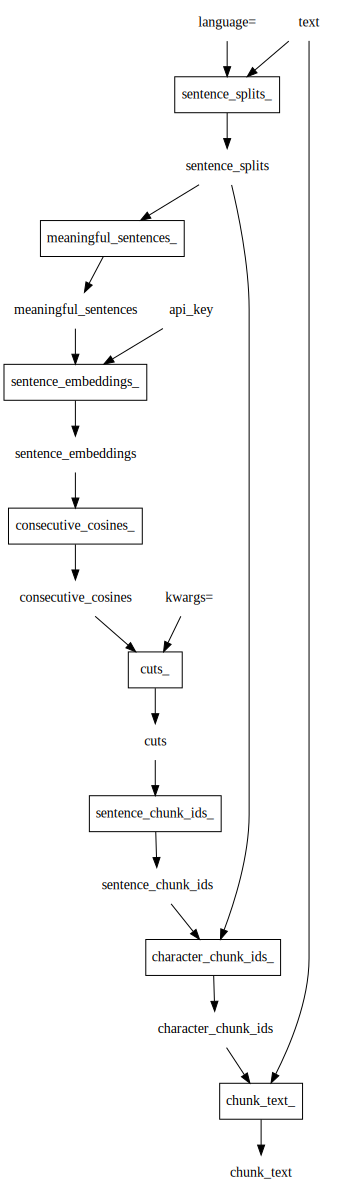

In [66]:
from meshed import DAG
funcs = [consecutive_cosines,
         sentence_embeddings,
        meaningful_sentences,
         cuts,
         sentence_chunk_ids,
        character_chunk_ids,
         sentence_splits,
                chunk_text,
        ]

dag = DAG(funcs)
dag.dot_digraph()

In [67]:
def segment_keys(documents, api_key, language='english'):
    segment_keys= []
    for doc_name, text in documents.items():
        character_chunk_ids = dag[:"character_chunk_ids"](language=language, text=text, api_key=api_key)
        for start, stop in character_chunk_ids:
            segment_keys.append((doc_name, start, stop))
    return segment_keys

In [68]:
txt = """
Monsters, Inc. is a 2001 American computer-animated comedy film produced by Pixar Animation Studios and distributed by Walt Disney Pictures. Featuring the voices of John Goodman, Billy Crystal, Steve Buscemi, James Coburn, and Jennifer Tilly, the film was directed by Pete Docter in his directorial debut, and executive produced by John Lasseter and Andrew Stanton. The film centers on two monsters – James P. "Sulley" Sullivan and his one-eyed partner and best friend Mike Wazowski – employed at the titular energy-producing factory Monsters, Inc, which generates power by scaring human children. The monster world believes that children are toxic, and when a small child enters the factory, Sulley and Mike must return her home before it is too late.""" 
# dag(text=txt, api_key=OPENAI_API_KEY)

segment_keys({"doc1": txt}, api_key=OPENAI_API_KEY)

[('doc1', 1, 366), ('doc1', 366, 597)]

# First testing of retrieval

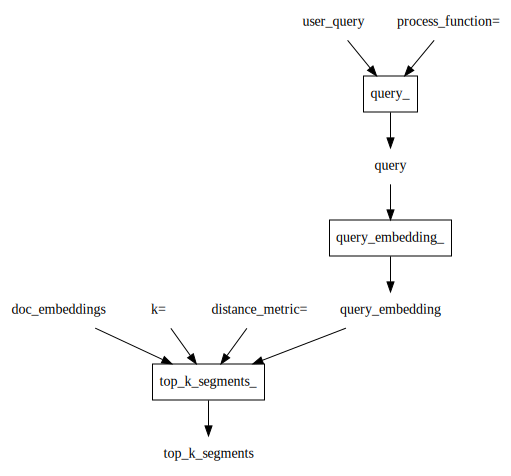

In [1]:
from raglab.retrieval.lib_alexis import dag, generate_split_keys
doc_embeddings = dag[:"doc_embeddings"]
top_k = dag["user_query":"top_k_segments"]
top_k.dot_digraph()

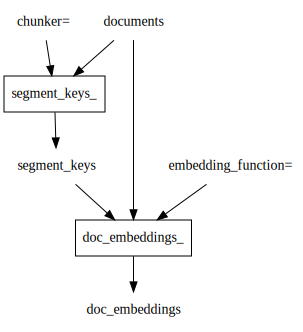

In [2]:
doc_embeddings.dot_digraph()

In [1]:
from dol import Files
f = Files("./data_ad")
d ={key: f[key].decode() for key in f} 

In [2]:
d

{'story.txt': "Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à construire des châteaux de sable.\n\nUn jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa grande surprise, une petite carte était enroulée à l'intérieur.\n\nLa carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à l'aventure pour trouver le trésor.\n\nIl marcha à travers la forêt dense, escalada des rochers escarpés et traversa des rivières tumultueuses. Finalement, après une longue journée d'aventure, Pierre arriva à l'endroit indiqué sur la carte.\n\nLà, sous un vieux chêne tordu, il creusa avec enthousiasme et découvrit un coffre rempli de pièc

In [51]:
from functools import partial
_generate_split_keys =  partial(generate_split_keys, chunk_overlap=40, chunk_size=300)

In [52]:
doc_embed = doc_embeddings(documents=d, chunker = _generate_split_keys) # TDODO add semantic chunker

In [53]:
from functools import partial
pipeline = partial(top_k, doc_embeddings=doc_embed)

In [54]:
test_set = {
    "Une personne qui habite une ville côtière": "dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre",
    "quel est le passe temps préféré du protagoniste": "Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à construire des châteaux de sable",
    "Pierre aperçois un objet lors d'une promenade, quel est il?": "Pierre découvrit une bouteille mystérieuse",
    "Que contenait la bouteille?": "petite carte était enroulée à l'intérieur",
    "Depuis combien de temps le trésor était-il caché?": "un trésor caché depuis des siècles",
    "Pierre pars chercher le trésor": "Pierre décida de partir à l'aventure",
    "Obstacles naturels sur le parcours": "forêt dense, escalada des rochers escarpés et traversa des rivières tumultueuses",
    "Combien de temps dur le trajet": "une longue journée",
    "contenu du trésor est magnigifique": "rempli de pièces d'or étincelantes et de joyaux étincelants",
    "a quels membre de son entourage partage-il la découverte?": "sa famille et à ses amis",
    "Quel est alors la réputation de Pierre dans sa ville": "connu comme le plus grand aventurier de la ville",
}    

In [55]:
score = 0
for query, responce in test_set.items():
    print(f"\n-------------\n Query: {query}")
    print(f"Expected: {responce}")
    res = pipeline(user_query=query, k=1)
    segment_key=res[0]
    if responce in d[segment_key[0]][segment_key[1]:segment_key[2]]:
        score += 1
        print("correct!")
    print(f"Predicted: {d[segment_key[0]][segment_key[1]:segment_key[2]]}")

print(f"\nScore: {score}/{len(test_set)}")



-------------
 Query: Une personne qui habite une ville côtière
Expected: dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre
correct!
Predicted: Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à construire des châteaux de sable.

-------------
 Query: quel est le passe temps préféré du protagoniste
Expected: Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à construire des châteaux de sable
Predicted: Il rentra chez lui en courant pour montrer son trésor à sa famille et à ses amis. À partir de ce jour-là, Pierre fut connu comme le plus grand aventurier de la ville, et chaque fois qu'il retournait à la plage, il se souvenait de l'excitation de sa grande aventure à la recherche du trésor caché.

-------------
 Query: Pierre aperçois un objet lors d'une promenade, quel est

# visualize embeddings

In [39]:
# dump .tsv file to save vectors
vectors = list(doc_embed.values()) + dag["user_query":"query_embedding"](user_query="Une personne qui habite une ville côtière")
labels = list(doc_embed.keys()) + ["Une personne qui habite une ville côtière"]


In [34]:
"a \n".replace("\n", "")

'a '

In [44]:
# visualisation of embaddings with labels
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(list(doc_embed.values()))
sentences = [d[key[0]][key[1]:key[2]] for key in doc_embed.keys()]
print(len(principalComponents), len(sentences))
sentence_embd = zip(sentences, principalComponents)
with open("embeddings_story.tsv", "w") as f:
    with open("embeddings_metadata_story.tsv", "w") as fm:
        for k, v in sentence_embd :
            fm.write(k.replace("\n", "") + "\n")
            f.write("\t".join([str(x).replace("\n", "") for x in v]) + "\n")
            print(v,k)


25 25
[ 0.263606   -0.16116216  0.24300912] Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à
[ 0.15252536 -0.03040171 -0.14722567] chercher des coquillages brillants et à construire des châteaux de sable.
[ 0.32028301 -0.09492968  0.2574581 ] Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa
[ 0.21093002  0.05010822 -0.19036478] pour voir ce qu'elle contenait. À sa grande surprise, une petite carte était enroulée à l'intérieur.
[ 0.2480553   0.02308763 -0.13970906] La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à l'aventure pour trouver le trésor.
[0.31339917 0.07151561 0.13113321] Il marcha à trave

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.00505012 -0.01125633  0.02729863 ... -0.01323909 -0.01103879
 -0.01737863].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [9]:
for k in doc_embed:
    print(d[k[0]][k[1]:k[2]])
    print("\n")

Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre.


vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à


ses journées à explorer les plages, à chercher des coquillages brillants et à construire des


brillants et à construire des châteaux de sable.


Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée


une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour


avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa grande surprise, une petite


À sa grande surprise, une petite carte était enroulée à l'intérieur.


La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles.


un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à


découverte, Pierre décida de partir à l'aventure pour trouver le trésor.


Il marcha à travers la